<a href="https://colab.research.google.com/github/hydro-7/Segmentation_Notebooks/blob/main/Failed_DLRSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Importing the Dataset from Local System**

In [1]:
!unzip DLRSD.zip

Archive:  DLRSD.zip
  inflating: DLRSD/Images/agricultural/agricultural00.tif  
  inflating: DLRSD/Images/agricultural/agricultural01.tif  
  inflating: DLRSD/Images/agricultural/agricultural02.tif  
  inflating: DLRSD/Images/agricultural/agricultural03.tif  
  inflating: DLRSD/Images/agricultural/agricultural04.tif  
  inflating: DLRSD/Images/agricultural/agricultural05.tif  
  inflating: DLRSD/Images/agricultural/agricultural06.tif  
  inflating: DLRSD/Images/agricultural/agricultural07.tif  
  inflating: DLRSD/Images/agricultural/agricultural08.tif  
  inflating: DLRSD/Images/agricultural/agricultural09.tif  
  inflating: DLRSD/Images/agricultural/agricultural10.tif  
  inflating: DLRSD/Images/agricultural/agricultural11.tif  
  inflating: DLRSD/Images/agricultural/agricultural12.tif  
  inflating: DLRSD/Images/agricultural/agricultural13.tif  
  inflating: DLRSD/Images/agricultural/agricultural14.tif  
  inflating: DLRSD/Images/agricultural/agricultural15.tif  
  inflating: DLRSD/I

# **2. Importing the Libraries**

In [2]:
import os

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms, datasets, models

import cv2
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import shutil

import requests
import zipfile
from pathlib import Path
from torch.utils.data import random_split

import random

from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm
from tqdm import tqdm

seed = 42

# **3. Setting up Data Directories**

Checking if the Dataset has been uploaded correctly, by checking the existance of the Image & Mask folders.

In [3]:
image_path = Path('/content/DLRSD/Images')
mask_path = Path('/content/DLRSD/Labels')

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print("Khel khatam")

if mask_path.is_dir():
    print(f"{mask_path} directory exists.")
else:
    print("Khel khatam")

/content/DLRSD/Images directory exists.
/content/DLRSD/Labels directory exists.


Checking if there are any images in the image_path folders.

Random image path: /content/DLRSD/Images/airplane/airplane16.tif
Image class: airplane
Image height: 256
Image width: 256


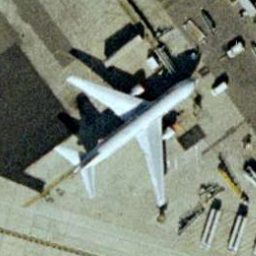

In [4]:
random.seed(seed)

# 1. Get all image paths (* means "any combination")

image_path_list = list(image_path.glob("*/*.tif"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

Checking number of image classes.

In [5]:
image_class_list = list(image_path.glob("*"))
print(len(image_class_list))

21


Making sure that the number of images in the Images dir == number of masks in the Labels dir.

In [6]:
mask_path_list = list(mask_path.glob("*/*.png"))
print(len(mask_path_list) == len(image_path_list))

True


# **4. Defining the Data-Paths & Directories**

In [ ]:
CLASSES = ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', "runway", "sparseresidential", "storagetanks", "tenniscourt"]

In [11]:
class DLRSDDataset(Dataset):

    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_paths=[]
        self.masks_paths=[]


        for class_name in CLASSES:

            self.image= os.listdir(os.path.join(self.image_dir, class_name))
            self.mask= os.listdir(os.path.join(self.mask_dir, class_name))

            for idx in range(100):

                self.image_paths.append(os.path.join(self.image_dir, class_name, self.image[idx]))
                self.masks_paths.append(os.path.join(self.mask_dir, class_name, self.mask[idx]).replace('.tif','.png'))

    def __len__(self):
        # return len(self.images_classes)*100
        return 2100

    def __getitem__(self, idx):

        image_path = self.image_paths[idx]
        mask_path = self.masks_paths[idx]


        image = Image.open(image_path).convert("RGB")
        mask  = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [38]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])


dataset = DLRSDDataset(image_dir='/content/DLRSD/Images', mask_dir='/content/DLRSD/Labels', transform=transform)


dataloader = DataLoader(dataset, batch_size=8, shuffle=True)



indices = list(range(len(dataset)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)


train_subset = Subset(dataset, train_indices)
test_subset = Subset(dataset, test_indices)


train_dataloader = DataLoader(train_subset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_subset, batch_size=8, shuffle=False)

In [25]:
dataset = DLRSDDataset(image_dir='/content/DLRSD/Images', mask_dir='/content/DLRSD/Labels', transform = transform)

# **5. Defining the UNET Architecture**

In [26]:
class Unet(nn.Module):
    def __init__(self, in_channels, n_class):
        super().__init__()
        #encoder
        self.e11= nn.Conv2d(3,64,kernel_size=3,padding=1)
        self.e12= nn.Conv2d(64,64,kernel_size=3,padding=1)
        self.pool1= nn.MaxPool2d(kernel_size=2,stride=2)

        self.e21= nn.Conv2d(64,128,kernel_size=3,padding=1)
        self.e22= nn.Conv2d(128,128,kernel_size=3,padding=1)
        self.pool2= nn.MaxPool2d(kernel_size=2,stride=2)

        self.e31= nn.Conv2d(128,256,kernel_size=3,padding=1)
        self.e32= nn.Conv2d(256,256,kernel_size=3,padding=1)
        self.pool3= nn.MaxPool2d(kernel_size=2,stride=2)

        self.e41= nn.Conv2d(256,512,kernel_size=3,padding=1)
        self.e42= nn.Conv2d(512,512,kernel_size=3,padding=1)
        self.pool4= nn.MaxPool2d(kernel_size=2,stride=2)

        self.e51= nn.Conv2d(512,1024,kernel_size=3,padding=1)
        self.e52= nn.Conv2d(1024,1024,kernel_size=3,padding=1)

        #decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)


        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256,128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)


    def forward(self,x):
        # Encoder
        xe11 = nn.ReLU()(self.e11(x))
        xe12 = nn.ReLU()(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = nn.ReLU()(self.e21(xp1))
        xe22 = nn.ReLU()(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = nn.ReLU()(self.e31(xp2))
        xe32 = nn.ReLU()(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = nn.ReLU()(self.e41(xp3))
        xe42 = nn.ReLU()(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = nn.ReLU()(self.e51(xp4))
        xe52 = nn.ReLU()(self.e52(xe51))

        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = nn.ReLU()(self.d11(xu11))
        xd12 = nn.ReLU()(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = nn.ReLU()(self.d21(xu22))
        xd22 = nn.ReLU()(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = nn.ReLU()(self.d31(xu33))
        xd32 = nn.ReLU()(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = nn.ReLU()(self.d41(xu44))
        xd42 = nn.ReLU()(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

In [27]:
model = Unet(in_channels = 3, n_class=21)

# **6. Running the training loop**

In [42]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    print(f"/n--------------Epoch: {epoch}------------/n")
    epoch_loss = 0
    model.train()
    for X, Y in tqdm(train_dataloader, total = len(train_dataloader), leave = False):


        Y = torch.squeeze(Y, dim=1)

        Y = Y.type(torch.LongTensor).astype('float32')


        # X, Y = X.to(device), Y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"loss: {epoch_loss/len(train_dataloader)}")

/n--------------Epoch: 0------------/n


loss: 0.0
/n--------------Epoch: 1------------/n


loss: 0.0
/n--------------Epoch: 2------------/n


loss: 0.0
/n--------------Epoch: 3------------/n


 32%|███▏      | 68/210 [03:12<06:51,  2.90s/it]